# Lucy in the sky with diamonds 

## Imports

In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.Cleaning_functions as fn
from scipy import stats
import math



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


## Some info:

**Carat**: Diamond **carat** weight measures how much a diamond weighs. All else being equal, diamond price increases with diamond **carat** weight because larger diamonds are rarer and more desirable. However, two diamonds of equal carat weight can have very different values (and prices) depending on three other factors of the diamond 4Cs: **Color**, **Clarity**, and **Cut**.
   
 **Color**: D-to-Z diamond color-grading system measures the degree of colorlessness by comparing a stone. 
   
 **Cut**: Diamond’s cut grade is really about how well a diamond’s facets interact with light.
 
 **Clarity**: 
     + Flawless (FL) No inclusions and no blemishes visible under 10x magnification
     + Internally Flawless (IF) No inclusions visible under 10x magnification
     + Very, Very Slightly Included (VVS1 and VVS2) Inclusions so slight they are difficult for a skilled grader to see under 10x magnification
     + Very Slightly Included (VS1 and VS2) Inclusions are observed with effort under 10x magnification, but can be characterized as minor
     + Slightly Included (SI1 and SI2) Inclusions are noticeable under 10x magnification
     + Included (I1, I2, and I3) Inclusions are obvious under 10x magnification which may affect transparency and brilliance
     
**x**: length in mm

**y**: width in mm

**z**: depth in mm

**depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table**: width of top of diamond relative to widest point (43--95)

*https://4cs.gia.edu/en-us/4cs-diamond-quality/*

## Explore the data

In [454]:
train = pd.read_csv('./INPUT/diamonds_train.csv') 
test = pd.read_csv('./INPUT/diamonds_test.csv')

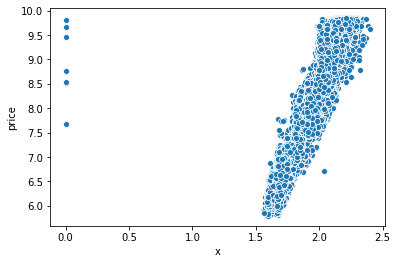

In [455]:
log_x = train['x'].apply(lambda x: np.log(x+1))
log_y = train['price'].apply(lambda x: np.log(x+1))
sns.scatterplot(log_x, log_y,  data=train)

## Data Engineering

Log transform target and relevat features:

In [436]:
feat = ['carat', 'x', 'y', 'z']
for e in feat:
    name = e + '_log'
    train[name] = train[e].apply(lambda x: np.log(x+1))
train.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price,carat_log,x_log,y_log,z_log
0,0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134,0.792993,2.045109,2.041220,1.654411
1,1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532,0.246860,1.637053,1.642873,1.297463
2,2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103,0.350657,1.768150,1.761300,1.376244


Let's try now with dummy variables for the categories:

clarity = ('IF', 'VVS2','VS1','VS2','SI1','SI2','I1' )
color = ('J', 'I', 'H', 'G', 'F', 'E', 'D')
cut = ('Premium', 'Ideal', 'Very Good', 'Good','Fair')
categories = fn.categorize([train.cut, train.color, train.clarity], [cut, color, clarity])

train_clean = pd.concat([train.drop(['Unnamed: 0', 'cut', 'color', 'clarity'], axis= 1) , categories], axis=1, sort=False )
train_clean.head(3)

In [456]:
train_clean = pd.get_dummies(train, prefix=['cut','color', 'clarity'])

In [457]:
train_clean.drop(['carat','x','y','z', 'depth', 'table'], axis= 1, inplace=True) 
print(train_clean.shape)
train_clean.head(3)

(40345, 26)


,Unnamed: 0,carat,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,1.21,6.73,6.70,4.23,6134,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0.28,4.14,4.17,2.66,532,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0.42,4.86,4.82,2.96,1103,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Remove outlayers:

In [459]:
#columns = ['x_log','y_log','z_log']
columns = ['x','y','z']

for col in columns:
    z = np.abs(stats.zscore(train_clean[col]))
    for i,e in enumerate(z):
        if e > 3:
            train_clean.drop(axis=0, index=i, inplace=True)
train_clean = train_clean.reset_index()
train_clean

KeyError: '[34399] not found in axis'

Standardize and normalize

In [440]:
pipeline = [
    StandardScaler(),
    #Normalizer()
]

tr = make_pipeline(*pipeline)

standard = tr.fit_transform(train_clean[['carat_log','x_log','y_log','z_log']])
df = pd.DataFrame(standard,columns=['carat_log_st','x_log_st','y_log_st','z_log_st'])
train_clean['carat_log'] = df['carat_log_st']
train_clean['x_log'] = df['x_log_st']
train_clean['y_log'] = df['y_log_st']
train_clean['z_log'] = df['z_log_st']

train_clean.tail(3)

,index,Unnamed: 0,price,carat_log,x_log,y_log,z_log,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
40315,40342,40342,1267,-0.422961,-0.288010,-0.283139,-0.245435,0,0,0,...,1,0,0,0,0,0,0,1,0,0
40316,40343,40343,9965,0.590126,0.720745,0.793296,0.557178,0,0,0,...,0,0,0,1,0,0,0,0,0,0
40317,40344,40344,1340,-0.502074,-0.288010,-0.351045,-0.430933,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [441]:
train_clean.drop(['index','Unnamed: 0'], axis=1, inplace=True)

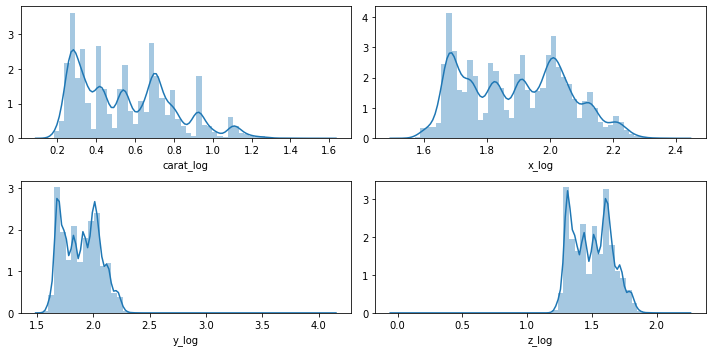

In [362]:
f, ax = plt.subplots(2,2, figsize=(10,5))
for i, e in enumerate(X.columns[:4]):
    sns.distplot(X[e], ax = ax[(i//2),(i if i<2 else i-2*(i//2))])
plt.tight_layout()

In [443]:
X_clean = train_clean.drop(['price'], axis= 1)
y = train_clean.price

### Models

In [445]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state = 0)

Regressors of classification models:

In [446]:
models = {
    "Kneighbors" : TransformedTargetRegressor(KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='auto', leaf_size=30,),
                                              func=np.log1p,
                                                inverse_func=np.expm1),
    #"RadiusKneighbors" : RadiusNeighborsRegressor(radius=1.0, weights='distance', algorithm='auto'),
    #"GradDescReg" : TransformedTargetRegressor(SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, random_state=0),
                                               #func=np.log1p,
                                                #inverse_func=np.expm1),
    "RandForest" : TransformedTargetRegressor(RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=2, random_state=0),
                                              func=np.log1p,
                                            inverse_func=np.expm1),
    "DecTreeReg": TransformedTargetRegressor(DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=0),
                                             func=np.log1p,
                                            inverse_func=np.expm1)
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train, y_train)
print('Training done')

Training model: Kneighbors
Training model: RandForest
Training model: DecTreeReg
Training done


In [447]:
#With log transformed target
#y_test_backtransformed =np.array([math.exp(e)-1 for e in y_test])
for name, model in models.items():
    print(f"---------[{name}]---------:")
    y_pred = model.predict(X_test)
    #y_pred_backtransformed =np.array([math.exp(e)-1 for e in y_pred])
    print("MSE = ",round(mean_squared_error(y_test,y_pred),5))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    print(r2_score(y_test, y_pred))


---------[Kneighbors]---------:
MSE =  385204.18761
RMSE =  620.6481995532185
0.9753290760110458
---------[RandForest]---------:
MSE =  306071.86164
RMSE =  553.2376176979321
0.9803972130197789
---------[DecTreeReg]---------:
MSE =  633032.10927
RMSE =  795.633149933325
0.9594566010629567


Strictly regression models:

In [413]:
models = {
    "LinearRegression" : TransformedTargetRegressor(LinearRegression(),
                                            func=np.log1p,
                                            inverse_func=np.expm1),
    "Ridge" : TransformedTargetRegressor(Ridge(alpha=1, tol=0.001, solver='auto', random_state=0),
                                         func=np.log1p,
                                            inverse_func=np.expm1),
    "Lasso" : TransformedTargetRegressor(Lasso(alpha=1, max_iter=1000, tol=0.0001),
                                         func=np.log1p,
                                            inverse_func=np.expm1),
    "ElasticNet" : TransformedTargetRegressor(ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, tol=0.0001, random_state=0),
                                              func=np.log1p,
                                            inverse_func=np.expm1),
    "BayesianRidge": TransformedTargetRegressor(BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06),
                                                func=np.log1p,
                                            inverse_func=np.expm1)
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train, y_train)

Training model: LinearRegression
Training model: Ridge
Training model: Lasso
Training model: ElasticNet
Training model: BayesianRidge


In [340]:
#With original target
for name, model in models.items():
    print(f"---------[{name}]---------:")
    y_pred = model.predict(X_test)
    results = pd.DataFrame({
    "GT":y_test,
    "pred":y_pred,
    "diff":y_pred-y_test
    })
    print("MSE = ",round(mean_squared_error(y_test,y_pred),5))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    #display(results)

---------[LinearRegression]---------:
MSE =  1219771.74463
RMSE =  1104.4327705360954
---------[Ridge]---------:
MSE =  1219795.0212
RMSE =  1104.44330827868
---------[Lasso]---------:
MSE =  1220260.7408
RMSE =  1104.6541272266516
---------[ElasticNet]---------:
MSE =  3528583.91501
RMSE =  1878.4525320090834
---------[BayesianRidge]---------:
MSE =  1219774.30109
RMSE =  1104.4339278970858


In [ ]:
mod = RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=2, random_state=0)
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
results = pd.DataFrame({
    "GT":y_test,
    "pred":y_pred,
    "diff":y_pred-y_test
    })
print("MSE = ",round(mean_squared_error(y_test,y_pred),5))
print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))

In [206]:
parameters = {
    'n_estimators':[100, 200, 300,700],
    'criterion':('mse', 'mae'),
    'max_features':["auto",'sqrt','log2'],
    'min_samples_split':[2,3,4,5]
}

rndfor_select = GridSearchCV(rndfor, parameters, verbose=4)
rndfor_select.fit(X_train, y_train)

sorted(rndfor_select.cv_results_.keys())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.979, total=  18.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.977, total=  18.3s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.7s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.979, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.8s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.978, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.978, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.979, total=  36.5s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.977, total=  36.6s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.979, total=  36.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.978, total=  36.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimato

[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.979, total=  51.4s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.977, total=  53.3s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.979, total=  51.8s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.978, total=  50.9s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.978, total=  50.9s
[CV] criterion=mae, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mae, min_samples_split=2, n_estimators=100, score=0.978, total=33.0min
[CV] criterion=mae, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mae, min_samples_split=2, n_estimato

KeyboardInterrupt: 

## Training with all the data:

In [448]:
mod = TransformedTargetRegressor(RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=2, random_state=0),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
mod.fit(X_clean,y)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
                           inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(bootstrap=True,
                                                           ccp_alpha=0.0,
                                                           criterion='mse',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           max_samples=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=2,
                                                           min_samples_split=4,
        

### Fixing test data:

In [468]:

feat = ['carat', 'x', 'y', 'z']
for e in feat:
    name = e + '_log'
    test[name] = test[e].apply(lambda x: np.log(x+1))
test_clean = pd.get_dummies(test, prefix=['cut','color', 'clarity'])
test_clean.drop(['carat','x','y','z', 'depth', 'table'], axis= 1, inplace=True) 
columns = ['x_log','y_log','z_log']

test_clean = test_clean.reset_index()
pipeline = [
    StandardScaler(),
    #Normalizer()
]

tr = make_pipeline(*pipeline)

standard = tr.fit_transform(test_clean[['carat_log','x_log','y_log','z_log']])
df = pd.DataFrame(standard,columns=['carat_log_st','x_log_st','y_log_st','z_log_st'])
test_clean['carat_log'] = df['carat_log_st']
test_clean['x_log'] = df['x_log_st']
test_clean['y_log'] = df['y_log_st']
test_clean['z_log'] = df['z_log_st']
test_clean.drop(['index','Unnamed: 0'], axis=1, inplace=True)


### Predicting

In [469]:
y_pred = mod.predict(test_clean)

### Preparing csv

In [470]:
result = pd.DataFrame({'id':test_clean.index, 'price':y_pred})
result

,id,price
0,0,416.263429
1,1,1629.039536
2,2,9023.718720
3,3,487.883046
4,4,8149.675954
...,...,...
13444,13444,4511.948548
13445,13445,441.585177
13446,13446,14374.802683
13447,13447,9980.201382


In [471]:
result.to_csv('./OUTPUT/submission2.csv', index=False)